# COMP3010J - Machine Learning - Kickstarter Project

## Yuyang Wang 19206226

# Import Necessary packages

In [92]:
# data analysis and preparing
import pandas as pd
import math
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm

# tqdm.pandas()

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree
from sklearn.metrics import auc, roc_curve, confusion_matrix, f1_score

# Read data file
Here we read the data as a DataFrame

* `ID`: internal kickstarter id
* `name`: name of project - A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or films.
* `category`: category
* `main_category`: category of campaign
* `currency`: currency used to support
* `deadline`: deadline for crowdfunding
* `goal`: fundraising goal - The funding goal is the amount of money that a creator needs to complete their project.
* `launched`: date launched
* `pledged`: amount pledged by "crowd"
* `state`: Current condition the project is in
* `usd pledged`: conversion in US dollars of the pledged column (conversion done by kickstarter).
* `usd_pledged_realised at deadline`: conversion in US dollars of the pledged column (conversion from Fixer.io API).
* `usd_goal_real_at_start`: conversion in US dollars of the goal column (conversion from Fixer.io API).

In [93]:
df = pd.read_csv('kickstarter201801.csv')

In [94]:
# df = pd.read_csv('./kickstarter201801.csv')

In [95]:
df.head()  # Take a look at first 5 lines

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,09/10/2015,1000.0,11/08/2015 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,01/11/2017,30000.0,02/09/2017 04:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,26/02/2013,45000.0,12/01/2013 00:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,16/04/2012,5000.0,17/03/2012 03:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,29/08/2015,19500.0,04/07/2015 08:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Check whether there exist missing data

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                378661 non-null  int64  
 1   name                              378657 non-null  object 
 2   category                          378661 non-null  object 
 3   main_category                     378661 non-null  object 
 4   currency                          378661 non-null  object 
 5   deadline                          378661 non-null  object 
 6   goal                              378661 non-null  float64
 7   launched                          378661 non-null  object 
 8   pledged                           378661 non-null  float64
 9   state                             378661 non-null  object 
 10  backers                           378661 non-null  int64  
 11  country                           378661 non-null  o

# Here we found there do exist missing data, I will deal with this problem later.

## Data analysis

In [97]:
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [98]:
df.describe(percentiles=[.1, .2, .6, .7, .8, .9, .95, .99])

,ID,goal,pledged,backers,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
10%,2.164103e+08,6.750000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.000000e+02
20%,4.312514e+08,1.500000e+03,1.000000e+01,1.000000,1.410000e+00,1.023000e+01,1.500000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
60%,1.290010e+09,9.000000e+03,1.411010e+03,23.000000,9.580000e+02,1.415000e+03,8.560180e+03
70%,1.502856e+09,1.250000e+04,2.925000e+03,42.000000,2.085000e+03,2.909000e+03,1.242221e+04
80%,1.716708e+09,2.080000e+04,5.729000e+03,76.000000,4.422754e+03,5.665220e+03,2.000000e+04


In [99]:
# Only categorical features
df.describe(include=['O'])

,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375722,159,15,14,3164,347035,6,23
top,#NAME?,Product Design,Film & Video,USD,08/08/2014,20/06/2017 16:00,failed,US
freq,43,22314,63585,295365,705,15,197719,292627


# Correlation

In [100]:
df[['main_category', 'usd pledged']].groupby(['main_category'], as_index=False).mean().sort_values(by='usd pledged',
                                                                                                   ascending=False)

,main_category,usd pledged
4,Design,17033.026574
8,Games,16306.194882
13,Technology,15457.306964
6,Film & Video,5532.577810
1,Comics,5344.016859
5,Fashion,4279.731233
7,Food,4209.934253
14,Theater,3554.355087
10,Music,3356.870405
3,Dance,2962.990149


In [101]:
df[['main_category', 'usd_goal_real_at_start']].groupby(['main_category'], as_index=False).mean().sort_values(
    by='usd_goal_real_at_start', ascending=False)

,main_category,usd_goal_real_at_start
13,Technology,102288.542838
9,Journalism,86003.395014
6,Film & Video,82625.292253
7,Food,49039.620802
8,Games,44923.741408
4,Design,41871.388591
0,Art,39198.575879
14,Theater,27088.321275
12,Publishing,24798.240254
5,Fashion,22412.409361


# Visualizing data

# Overview of our target feature

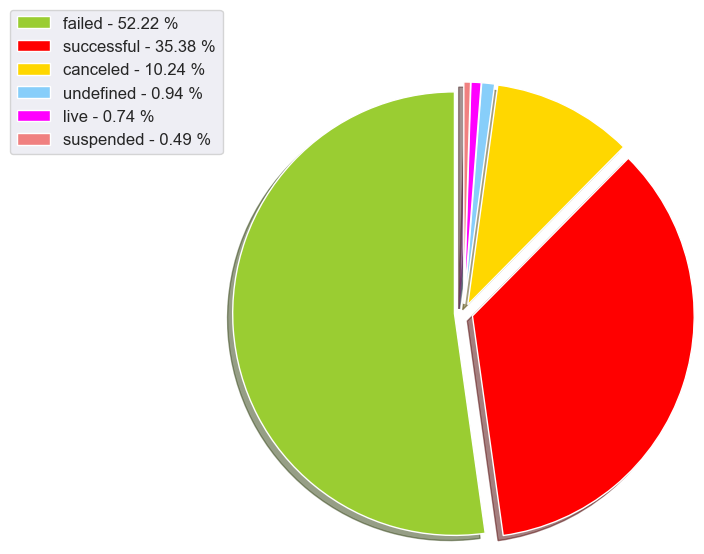

In [102]:
fig = plt.figure(figsize=(28, 6))
state_value_counts = df['state'].value_counts()
x = np.char.array([str(i) for i in state_value_counts.index])
y = np.array(state_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(state_value_counts.index)]
explode = [0.05] * len(state_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

# Unbalance data

# Drop state `undefined` and `live`

* `undefined`: means that the state is unknown and should be dropped.
* `live`: on-going project.

In [103]:
df = df[df['state'] != "undefined"]
df = df[df['state'] != "live"]
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,09/10/2015,1000.0,11/08/2015 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,01/11/2017,30000.0,02/09/2017 04:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,26/02/2013,45000.0,12/01/2013 00:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,16/04/2012,5000.0,17/03/2012 03:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,29/08/2015,19500.0,04/07/2015 08:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


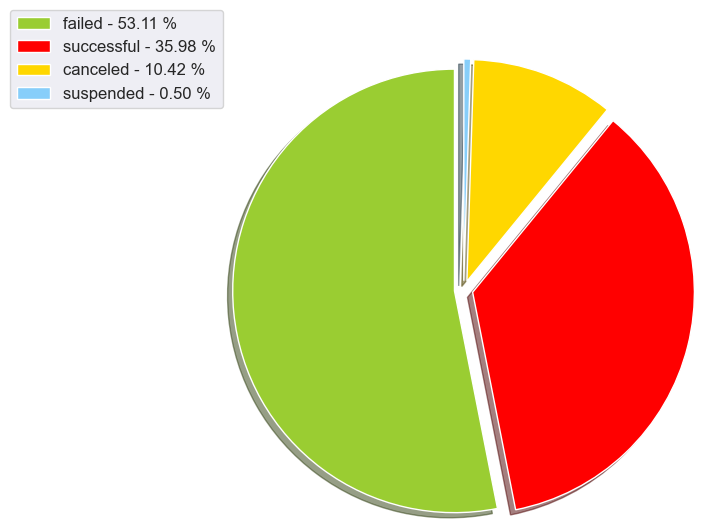

In [104]:
fig = plt.figure(figsize=(28, 6))
state_value_counts = df['state'].value_counts()
x = np.char.array([str(i) for i in state_value_counts.index])
y = np.array(state_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(state_value_counts.index)]
explode = [0.05] * len(state_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

# Unbalance data

# Firstly we take a look at `goal` and `pledged`

Here `goal` and `pledged` are unconverted value (i.e. in their own currency)

<AxesSubplot: xlabel='state', ylabel='pledged'>

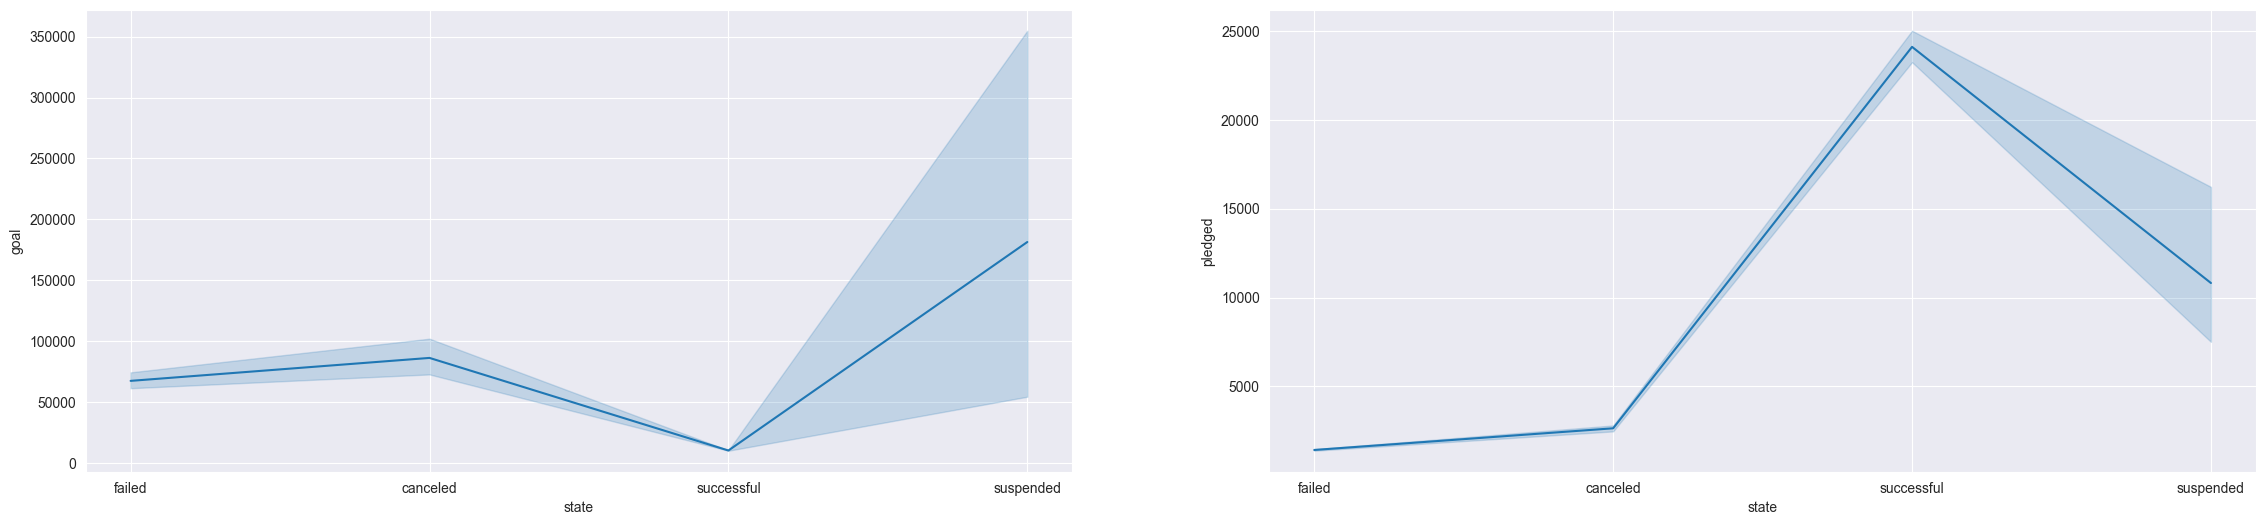

In [105]:
fig = plt.figure(figsize=(28, 6))

ax = fig.add_subplot(121)
sns.lineplot(x='state', y='goal', data=df, ax=ax)

ax = fig.add_subplot(122)
sns.lineplot(x='state', y='pledged', data=df, ax=ax)


# From the graph we know that...

Here, we know that the goal of a kickstarter project is really high. Then, this project might be **suspended**.
So `goal` column is a good descriptive feature for us to determine whether a project will get **suspend** or not.

# What if we convert this to USD ?

 I found the following information from the Internet.

* `usd_goal_real_at_start`: conversion in US dollars of the goal column (conversion from Fixer.io API).
* `usd pledged`: conversion in US dollars of the pledged column (conversion done by kickstarter).
* `usd_pledged_realised at deadline`: conversion in US dollars of the pledged column (conversion from Fixer.io API).


<AxesSubplot: xlabel='state', ylabel='usd_pledged_realised at deadline'>

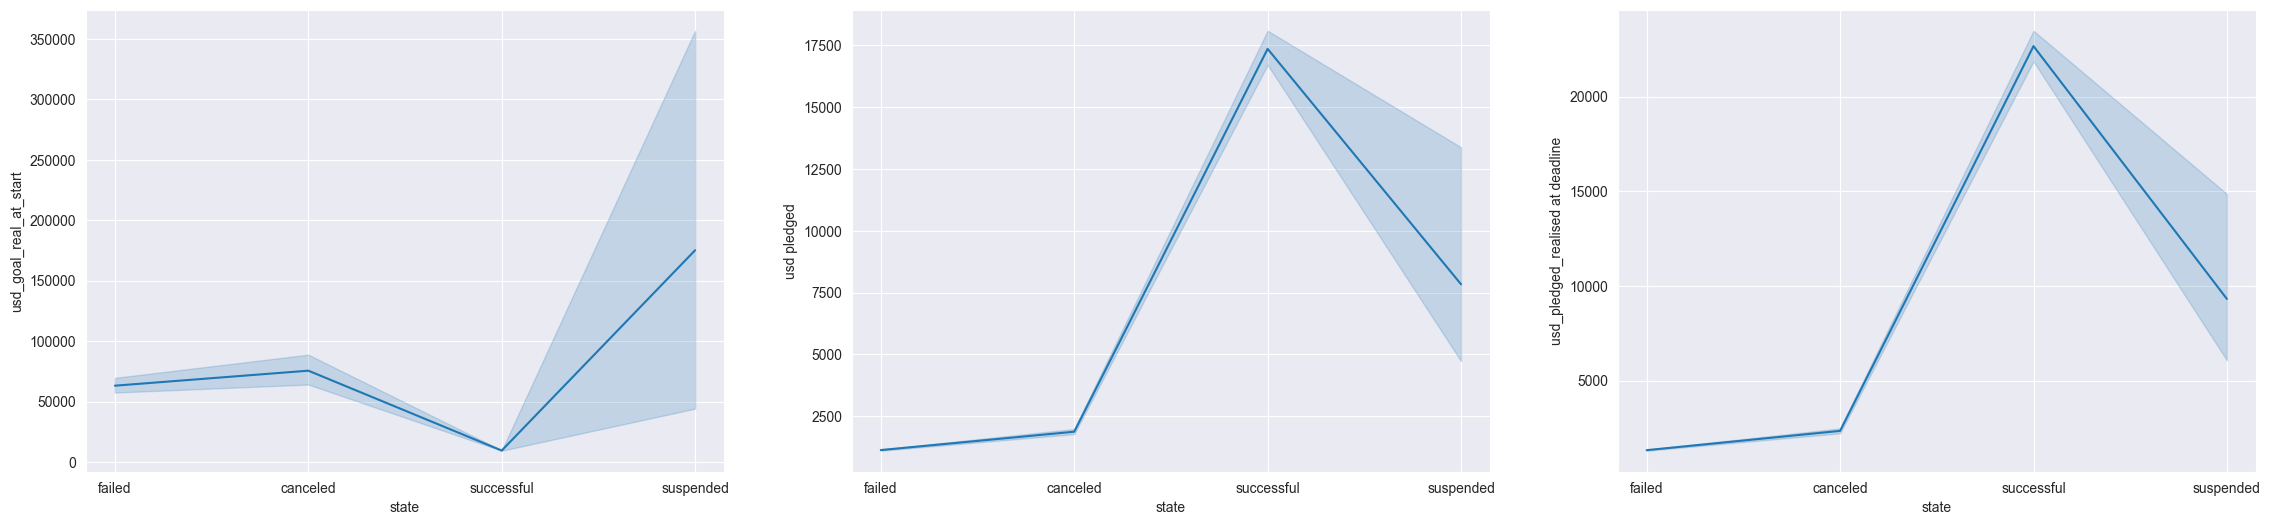

In [106]:
fig = plt.figure(figsize=(28, 6))

ax = fig.add_subplot(131)
sns.lineplot(x='state', y='usd_goal_real_at_start', data=df, ax=ax)  # Converted by third-party API (goal)

ax = fig.add_subplot(132)
sns.lineplot(x='state', y='usd pledged', data=df, ax=ax)  # Converted by kickstarter (pledged)

ax = fig.add_subplot(133)
sns.lineplot(x='state', y='usd_pledged_realised at deadline', data=df, ax=ax)  #  Converted by third-party API (pledged)

# Why dose this dataset contains both third-party API converted pledged value and kickstarter Converted?
We need to take a look at the value between:
* `pledged` (unconverted pledged value)
* `usd pledged` (pledged value converted by kickstarter)
* `usd_pledged_realised at deadline` (pledged value by third-party API)

<AxesSubplot: xlabel='state', ylabel='usd_pledged_realised at deadline'>

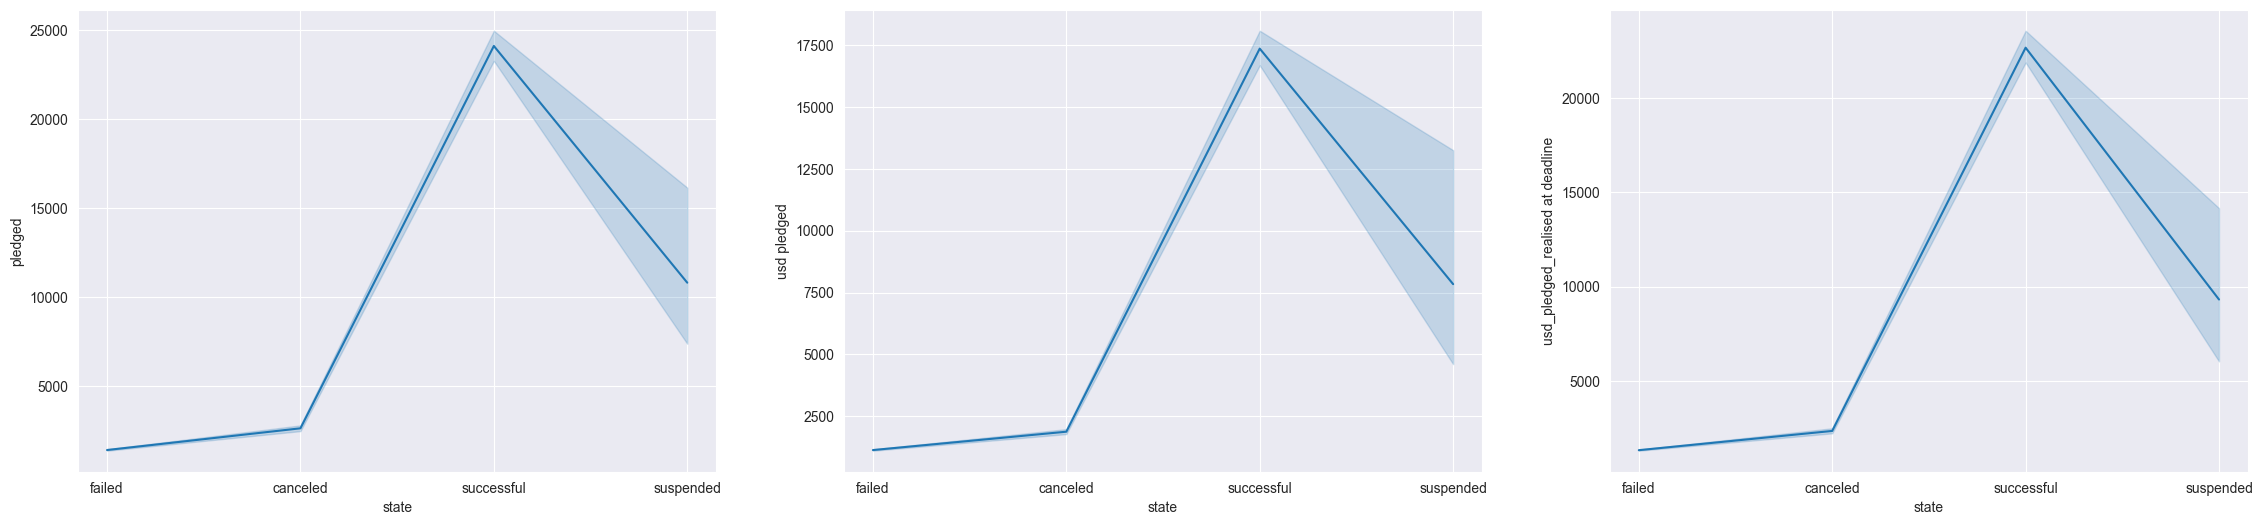

In [107]:
fig = plt.figure(figsize=(28, 6))

ax = fig.add_subplot(131)
sns.lineplot(x='state', y='pledged', data=df, ax=ax)  # Converted by third-party API (goal)

ax = fig.add_subplot(132)
sns.lineplot(x='state', y='usd pledged', data=df, ax=ax)  # Converted by kickstarter (pledged)

ax = fig.add_subplot(133)
sns.lineplot(x='state', y='usd_pledged_realised at deadline', data=df, ax=ax)  #  Converted by third-party API (pledged)

# From the figure we can know that...

* The characteristic of `pledged` and `usd_pledged_realised at deadline` are quite similar
* However, the figure of `usd pledged` is **significantly** different from these two figures

We need to take some sample to find out why this is the case.

In [108]:
df.head(10)  # Take head 10 sample

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,09/10/2015,1000.0,11/08/2015 12:12,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,01/11/2017,30000.0,02/09/2017 04:43,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,26/02/2013,45000.0,12/01/2013 00:20,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,16/04/2012,5000.0,17/03/2012 03:24,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,29/08/2015,19500.0,04/07/2015 08:35,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,01/04/2016,50000.0,26/02/2016 13:38,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,21/12/2014,1000.0,01/12/2014 18:30,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,17/03/2016,25000.0,01/02/2016 20:05,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,29/05/2014,125000.0,24/04/2014 18:14,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,10/08/2014,65000.0,11/07/2014 21:55,6240.57,canceled,43,US,6240.57,6240.57,65000.00


# Let's take 1000003930 (ID) as an example

In [109]:
print(f"The 'currency'                         of this project: {df[df['ID'] == 1000003930]['currency'][1]}")
print(f"The 'pledged'                          of this project: {df[df['ID'] == 1000003930]['pledged'][1]}")
print(f"The 'usd pledged'                      of this project: {df[df['ID'] == 1000003930]['usd pledged'][1]}")
print(
    f"The 'usd_pledged_realised at deadline' of this project: {df[df['ID'] == 1000003930]['usd_pledged_realised at deadline'][1]}")

The 'currency'                         of this project: USD
The 'pledged'                          of this project: 2421.0
The 'usd pledged'                      of this project: 100.0
The 'usd_pledged_realised at deadline' of this project: 2421.0


# Here we found a problem...

Here the `currency` of this project is "USD", so the value in column `pledged` is "USD", after conversion, the value should not be changed.

However, in the `usd pledge` column, this value got be changed to 100.0, which is incorrect.

The value of `usd_pledged_realised at deadline` is the equal to `pledged`, which is right.

## So...How many lines contain error like this?

Let's try "USD" and find out!

In [110]:
print(f"\tTotal projects using USD :                                  {len(df[(df['currency'] == 'USD')])}")
print("For the projects using USD as their currency:")
print(
    f"\t'pledged' equal to 'usd pledged' :                          {len(df[(df['currency'] == 'USD') & (df['pledged'] == df['usd pledged'])])}")
print(
    f"\t'pledged' not equal to 'usd pledged' :                      {len(df[(df['currency'] == 'USD') & (df['pledged'] != df['usd pledged'])])}")
print(
    f"\t'pledged' equal to 'usd_pledged_realised at deadline' :     {len(df[(df['currency'] == 'USD') & (df['pledged'] == df['usd_pledged_realised at deadline'])])}")
print(
    f"\t'pledged' not equal to 'usd_pledged_realised at deadline' : {len(df[(df['currency'] == 'USD') & (df['pledged'] != df['usd_pledged_realised at deadline'])])}")

	Total projects using USD :                                  291054
For the projects using USD as their currency:
	'pledged' equal to 'usd pledged' :                          248253
	'pledged' not equal to 'usd pledged' :                      42801
	'pledged' equal to 'usd_pledged_realised at deadline' :     291054
	'pledged' not equal to 'usd_pledged_realised at deadline' : 0


# So, `usd pledged` is wrong for at least 46581 kickstarter projects!

However, `usd_pledged_realised at deadline` is right.

Which means `usd pledged` should be **dropped**.

In [111]:
df.drop(['usd pledged'], inplace=True, axis=1)

# Then we take a look at number of `backers`.

<AxesSubplot: xlabel='state', ylabel='usd_pledged_realised at deadline'>

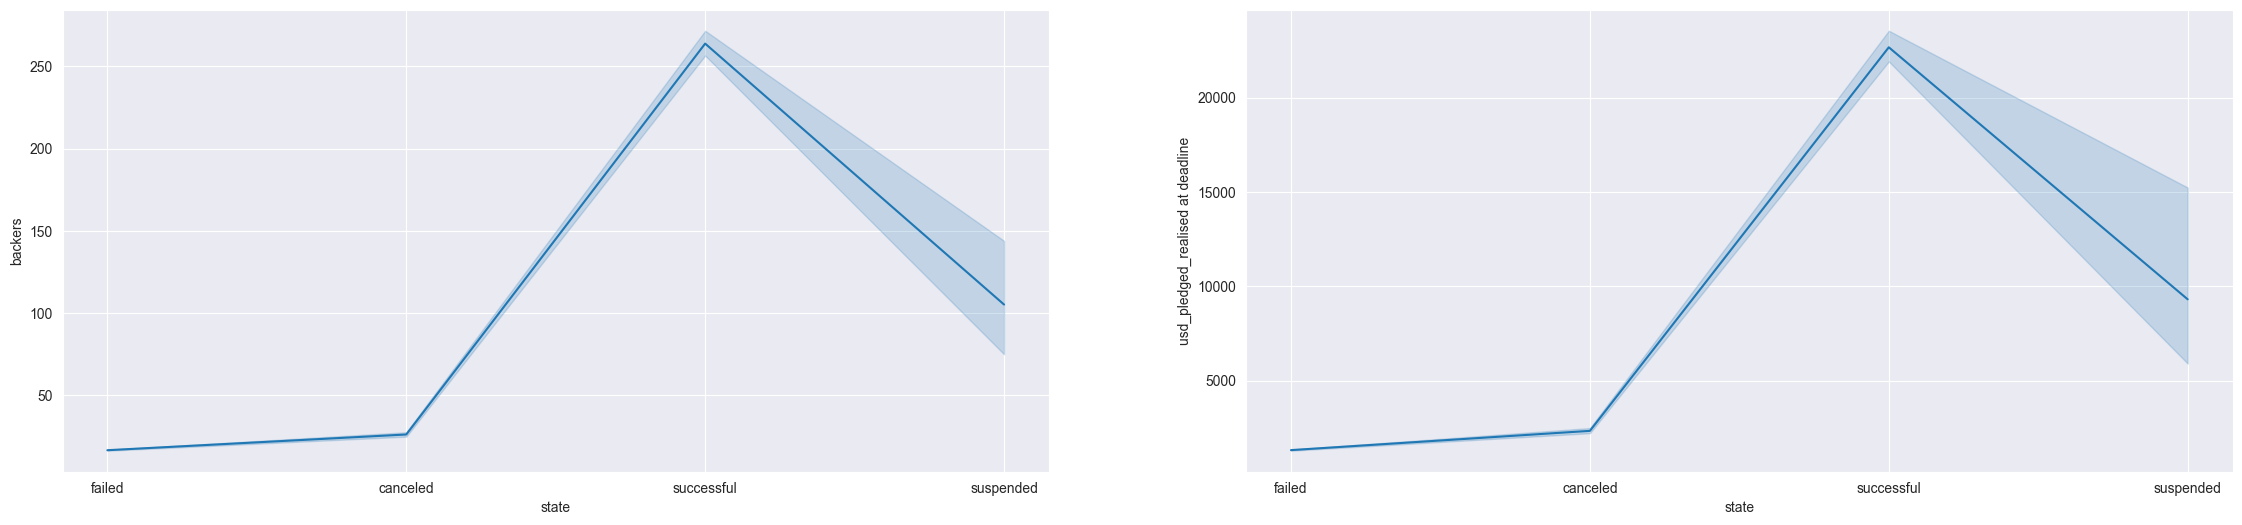

In [112]:
fig = plt.figure(figsize=(28, 6))

ax = fig.add_subplot(121)
sns.lineplot(x='state', y='backers', data=df)  # Bankers

ax = fig.add_subplot(122)
sns.lineplot(x='state', y='usd_pledged_realised at deadline', data=df, ax=ax)  #  Converted by third-party API (pledged)

# From the graph we know...

The overall characteristic of number of `bankers` and `usd_pledged_realised at deadline` are quite similar
**They all reflect the probability of whether a kickstarter project belongs to which class.**

<AxesSubplot: xlabel='state', ylabel='backers'>

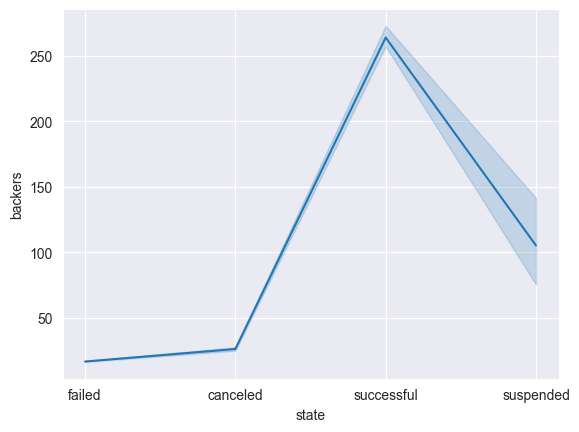

In [113]:
sns.lineplot(x='state', y='backers', data=df)

<AxesSubplot: xlabel='state', ylabel='usd_goal_real_at_start'>

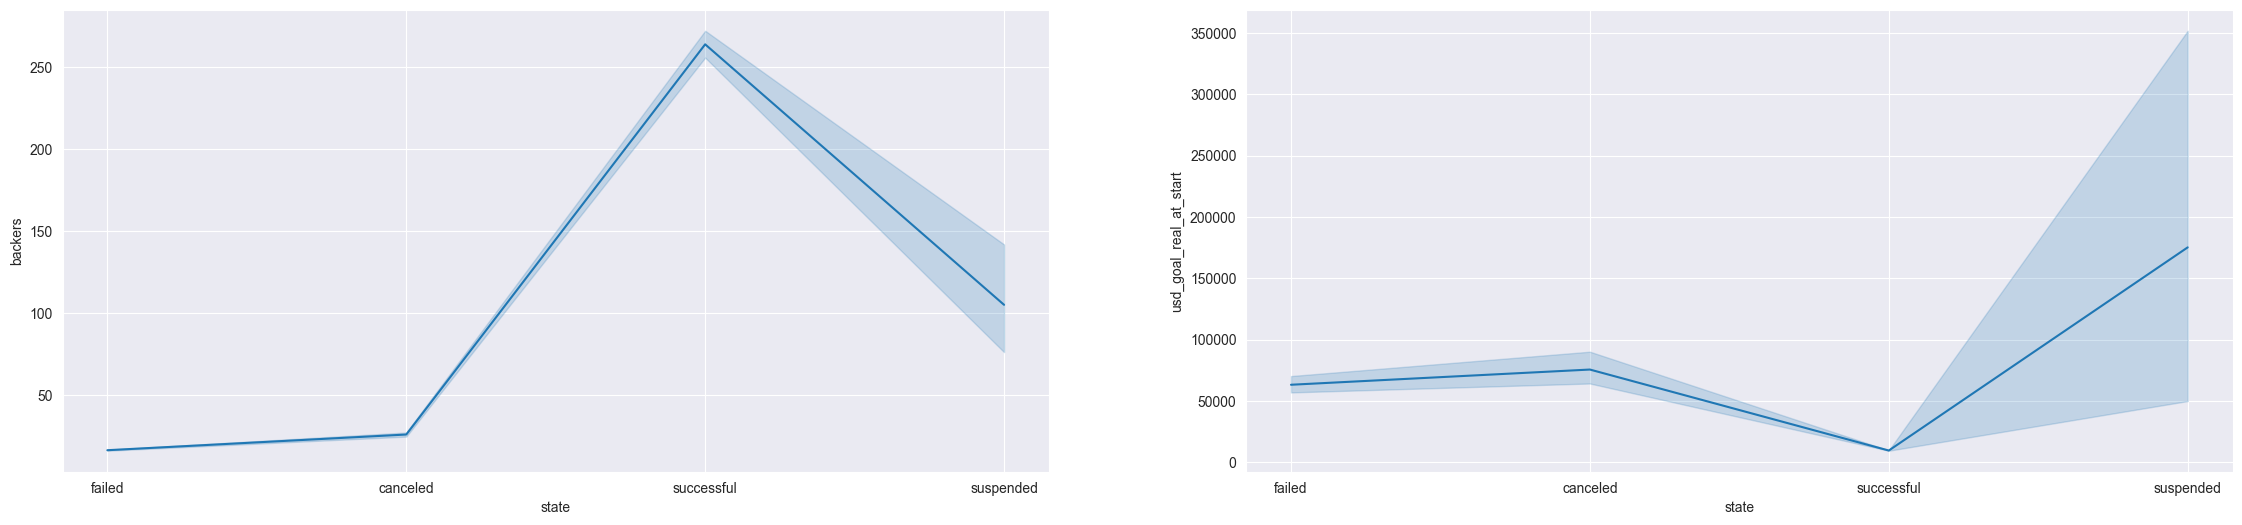

In [114]:
fig = plt.figure(figsize=(28, 6))

ax = fig.add_subplot(121)
sns.lineplot(x='state', y='backers', data=df, ax=ax)

ax = fig.add_subplot(122)
sns.lineplot(x='state', y='usd_goal_real_at_start', data=df, ax=ax)

# Dose `category` or `main_category` have effects on the `state` of a kickstarter project?

Firstly, let's check some basic information.

In [115]:
print(f"We have {len(set(df['main_category']))} unique main_category value.")
print(f"We have {len(set(df['category']))} unique category value.")

We have 15 unique main_category value.
We have 159 unique category value.


# Firstly we take a look at main_category

Data is distributed in these main categories, whereas Film & Video take a majority part in this data.

<AxesSubplot: xlabel='main_category', ylabel='Count'>

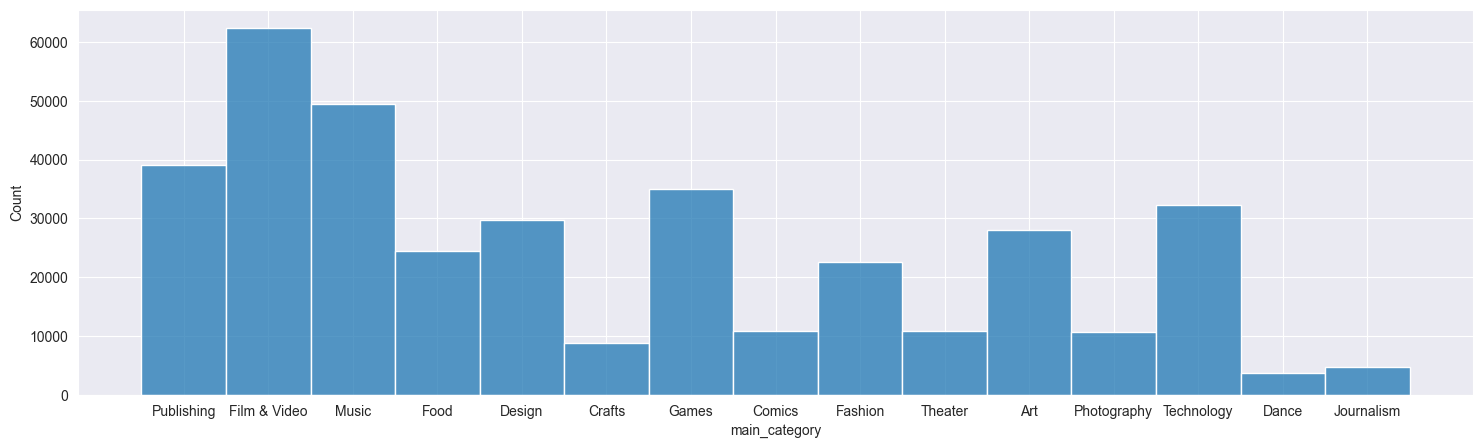

In [116]:
plt.figure(figsize=(18, 5))  #adjust the size of plot
sns.histplot(x='main_category', data=df, bins=20, stat='count', multiple='stack')

# The `main_category` is somewhat related to the state of the kickstarter project.

<AxesSubplot: xlabel='main_category', ylabel='Count'>

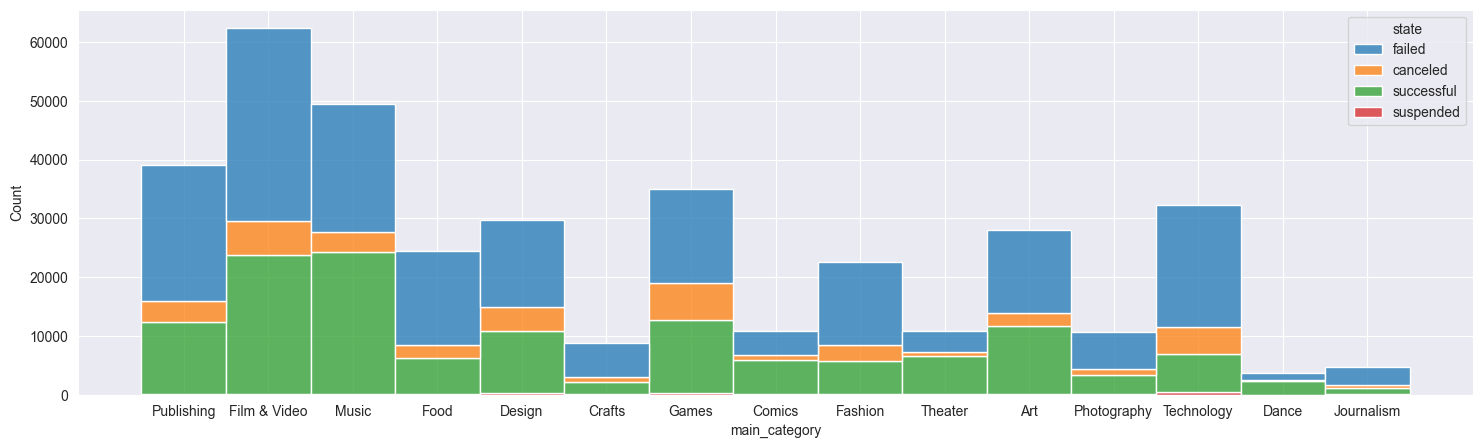

In [117]:
plt.figure(figsize=(18, 5))  #adjust the size of plot
sns.histplot(x='main_category', hue="state", data=df, bins=20, stat='count', multiple='stack')

In [118]:
pd.crosstab(df['main_category'], df['state']).div(pd.crosstab(df['main_category'], df['state']).sum(axis=1), axis=0)

state,canceled,failed,successful,suspended
main_category,,,,
Art,0.079474,0.505419,0.411674,0.003434
Comics,0.078377,0.375686,0.543796,0.002141
Crafts,0.096530,0.653040,0.242185,0.008245
Dance,0.043478,0.329421,0.623633,0.003468
Design,0.139502,0.497732,0.354467,0.008299
Fashion,0.117449,0.628551,0.247884,0.006116
Film & Video,0.092229,0.527316,0.378580,0.001875
Food,0.090548,0.653985,0.249201,0.006266
Games,0.177489,0.457974,0.358241,0.006296


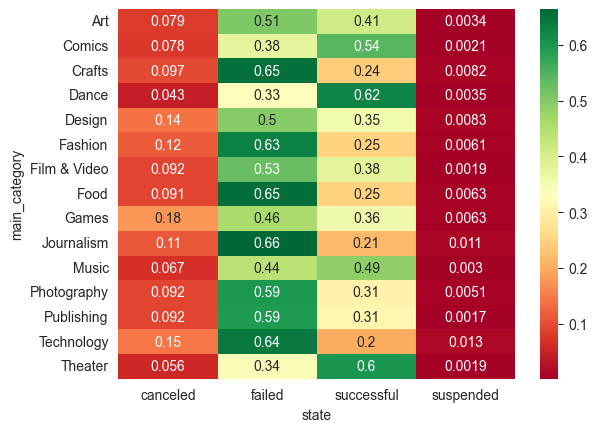

In [119]:
g = sns.heatmap(
    pd.crosstab(df['main_category'], df['state']).div(pd.crosstab(df['main_category'], df['state']).sum(axis=1),
                                                      axis=0), annot=True, cmap="RdYlGn")

# From the heatmap we can know that.

* Nearly 63% of Music project goes to undefined state.
* 18% Film & Video, 18% Music project succeed.
* ...

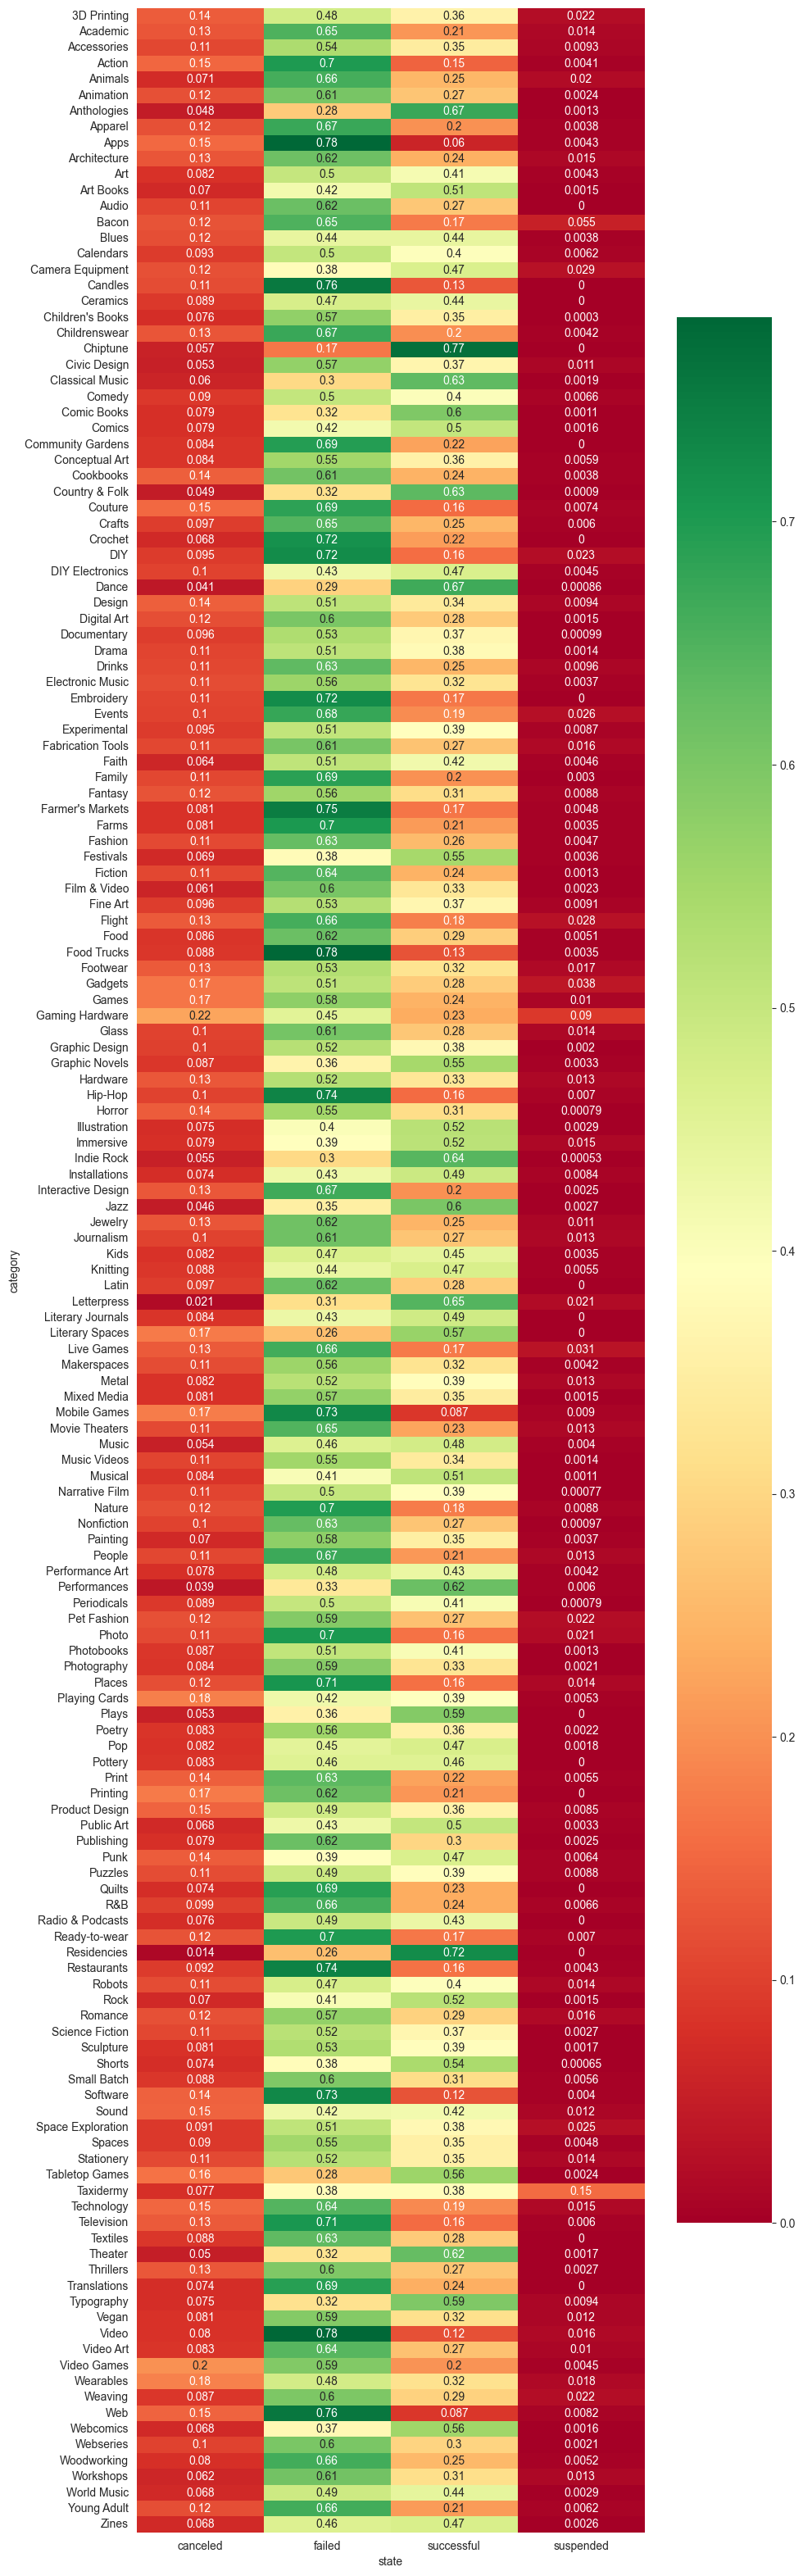

In [120]:
plt.figure(figsize=(10, 40))  #adjust the size of plot
g = sns.heatmap(
    pd.crosstab(df['category'], df['state']).div(pd.crosstab(df['category'], df['state']).sum(axis=1), axis=0),
    annot=True, cmap="RdYlGn")

# From the graph above we know that both `main_category` and `category` are not good to determine the state of the project.


# Will the length of `name` related to the `state` of a kickstarter project?

We firstly take a look at the distribution of the project name length.

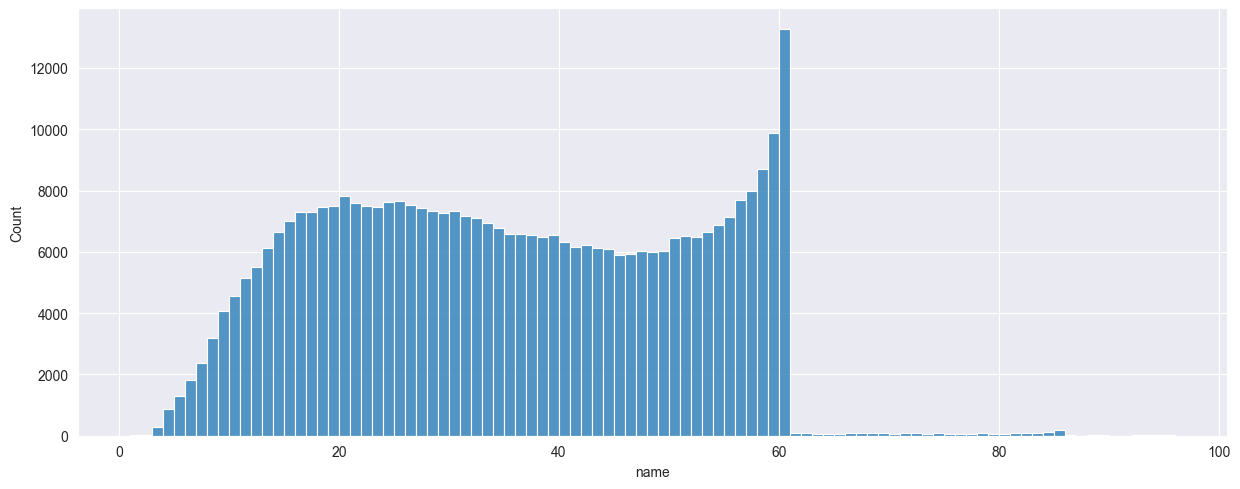

In [121]:
sns.displot(df['name'].apply(lambda x: len(str(x))), binwidth=1, aspect=2.5)

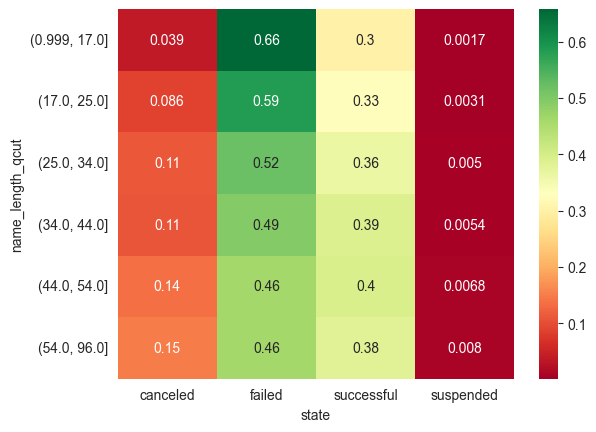

In [122]:
df['name_length'] = df['name'].apply(lambda x: len(str(x)))
df['name_length_qcut'] = pd.qcut(df['name_length'], 6)
g = sns.heatmap(
    pd.crosstab(df['name_length_qcut'], df['state']).div(pd.crosstab(df['name_length_qcut'], df['state']).sum(axis=1),
                                                         axis=0), annot=True, cmap="RdYlGn")

In [123]:
df['name_length_qcut'].value_counts()

(25.0, 34.0]     64839
(34.0, 44.0]     63686
(0.999, 17.0]    63553
(44.0, 54.0]     62888
(17.0, 25.0]     60581
(54.0, 96.0]     56753
Name: name_length_qcut, dtype: int64

# Here are the things that we found

* If the length of a project's name is too short, then this project is more likely to fail
* As the length of a project's name goes greater, this project is more likely to be canceled.

So, we keep the field `name_length` and `name_length_qcut` and drop `name` field.

In [124]:
df.drop("name", inplace=True, axis=1)

# Dose the currency affects the state of the project?

In [125]:
df['currency'].value_counts()

USD    291054
GBP     33417
EUR     16914
CAD     14629
AUD      7777
SEK      1738
MXN      1645
NZD      1436
DKK      1100
CHF       747
NOK       702
HKD       583
SGD       527
JPY        31
Name: currency, dtype: int64

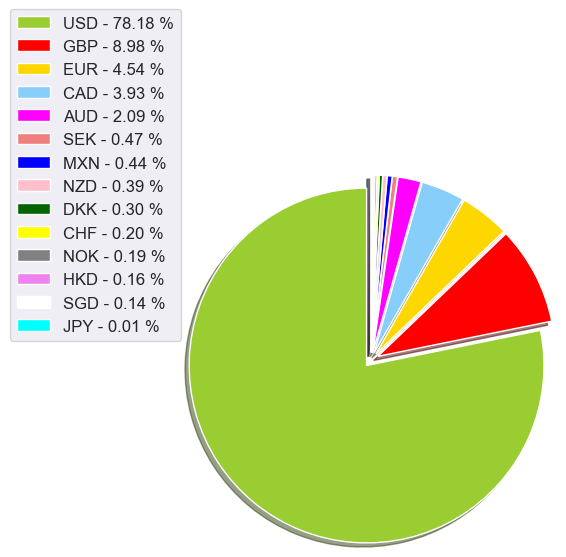

In [126]:
state_value_counts = df['currency'].value_counts()
x = np.char.array([str(i) for i in state_value_counts.index])
y = np.array(state_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(state_value_counts.index)]
explode = [0.05] * len(state_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

# According to the heatmap below, we can conclude that the `currency` column does not have a significant impact on whether a kickstarter project will success or not.

The `currency` field will be dropped later.

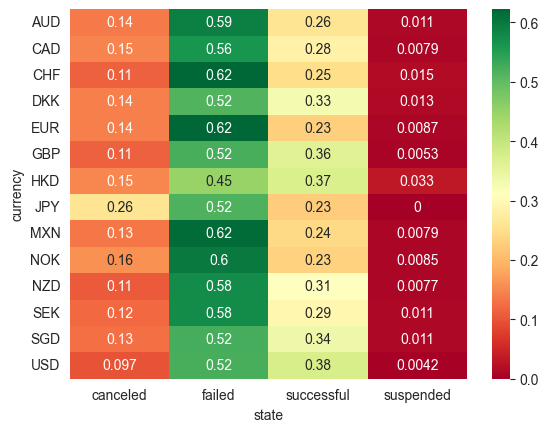

In [127]:
g = sns.heatmap(
    pd.crosstab(df['currency'], df['state']).div(pd.crosstab(df['currency'], df['state']).sum(axis=1), axis=0),
    annot=True, cmap="RdYlGn")

# From the heatmap we know that the currency they use does not have a significant effect on the state of a project

So, we drop currency column.

I will drop this colum later.

# When it comes to date, we add duration field.

* Because, if the duration of a project is long, then this might indicate that the project goes will and are more likely to success.
* However, the duration of a project is short, this might indicate that the project got suspend or canceled.

In [128]:
df["duration"] = (pd.to_datetime(df.deadline, format="%d/%m/%Y") - pd.to_datetime(df.launched,
                                                                                  format="%d/%m/%Y %H:%M")).apply(
    lambda x: x.days)

<AxesSubplot: xlabel='state', ylabel='duration'>

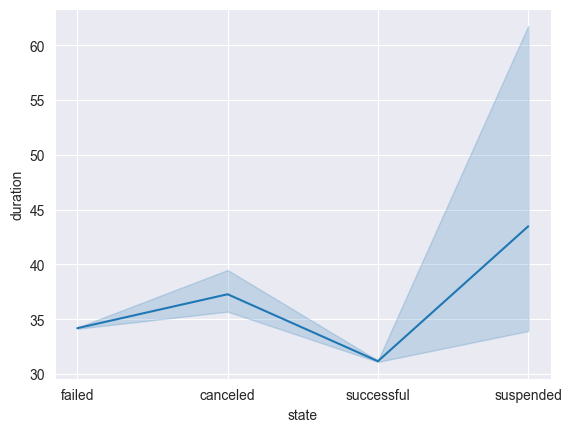

In [129]:
sns.lineplot(x='state', y='duration', data=df)

From the heatmap below we can know that, the duration between (44,59] are more likely to success.

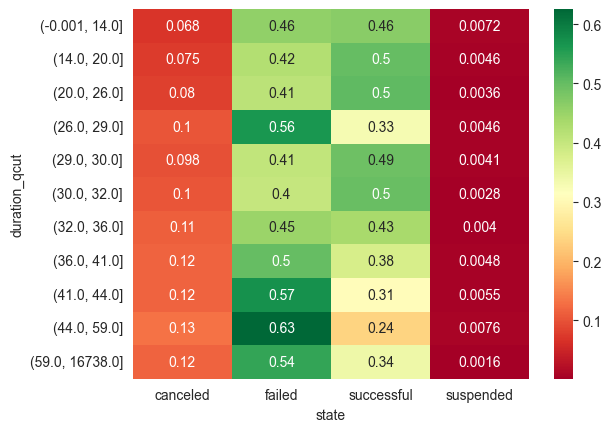

In [130]:
df['duration_qcut'] = pd.qcut(df['duration'], 20, duplicates='drop')
g = sns.heatmap(
    pd.crosstab(df['duration_qcut'], df['state']).div(pd.crosstab(df['duration_qcut'], df['state']).sum(axis=1),
                                                      axis=0), annot=True, cmap="RdYlGn")

# Then we can drop `launched` and `deadline` column.

In [131]:
df.drop(['launched', 'deadline'], inplace=True, axis=1)

# From the heatmap we know that...

* If the duration of a project is too short or too long, then this project is more likely failed.


# Instead of using `usd_pledged_realised at deadline` and `usd_goal_real_at_start` directly, we add a `completeRatio` field.

In [132]:
df["completeRatio"] = df['usd_pledged_realised at deadline'] / df['usd_goal_real_at_start']

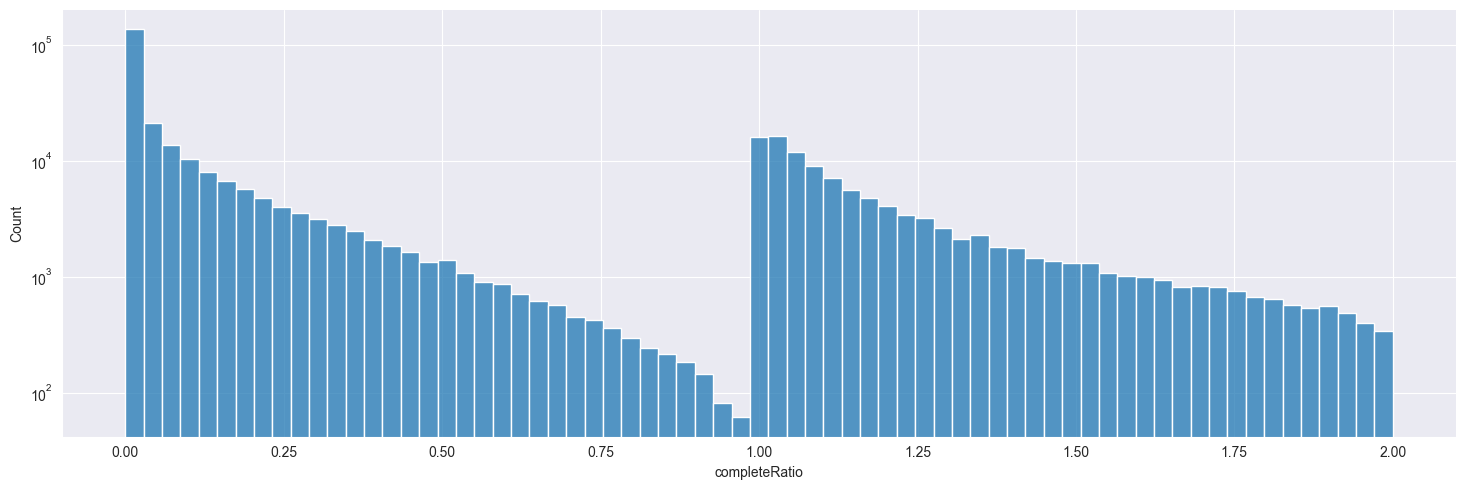

In [133]:
ax = sns.displot(df[df['completeRatio'] < 2]['completeRatio'], aspect=3)
ax.set(yscale="log")

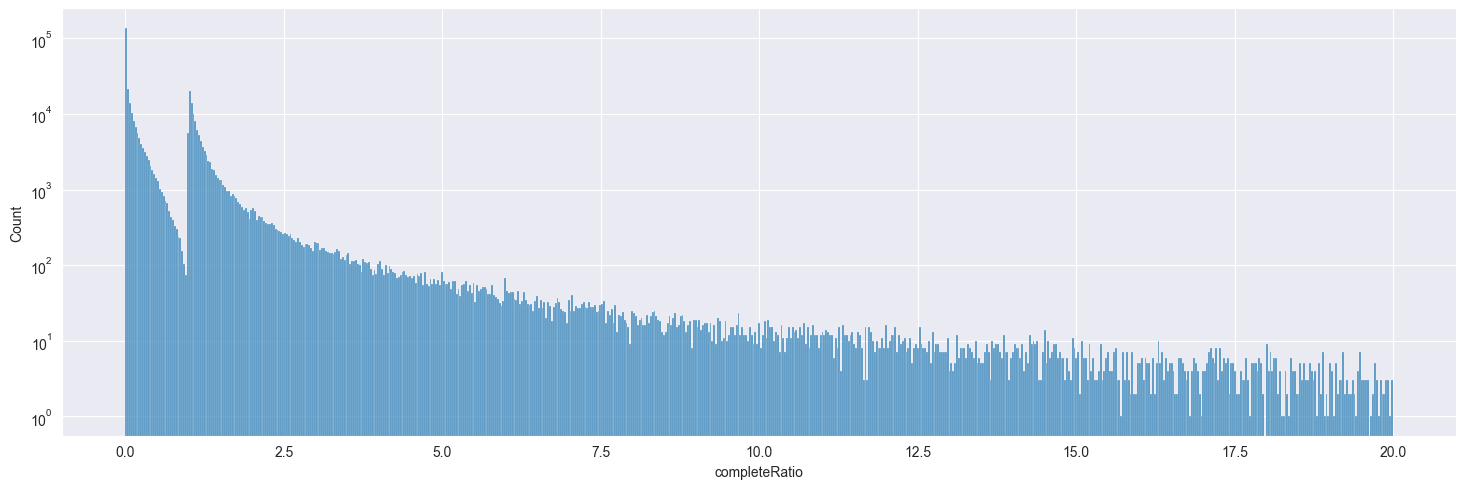

In [134]:
ax = sns.displot(df[df['completeRatio'] < 20]['completeRatio'], aspect=3)
ax.set(yscale="log")

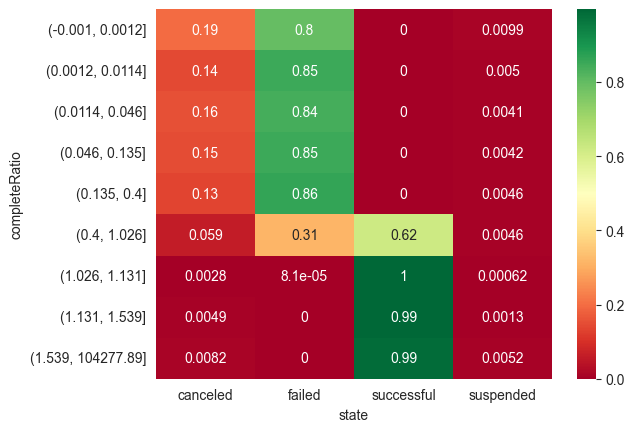

In [135]:
g = sns.heatmap(pd.crosstab(pd.qcut(df['completeRatio'], 10, duplicates='drop'), df['state']).div(
    pd.crosstab(pd.qcut(df['completeRatio'], 10, duplicates='drop'), df['state']).sum(axis=1), axis=0), annot=True,
    cmap="RdYlGn")

# Dose `country` have effects on `state`?

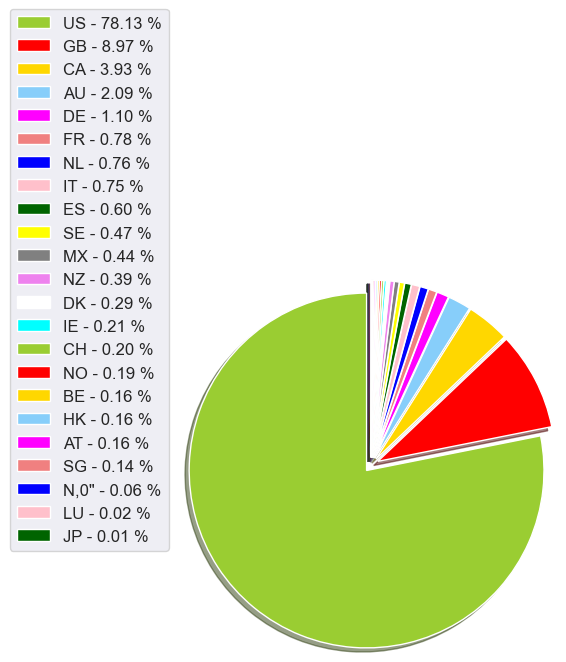

In [136]:
state_value_counts = df['country'].value_counts()
x = np.char.array([str(i) for i in state_value_counts.index])
y = np.array(state_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(state_value_counts.index)]
explode = [0.05] * len(state_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

# From the heatmap below we can conclude that `country` is not a good feature to determine the state of a project.

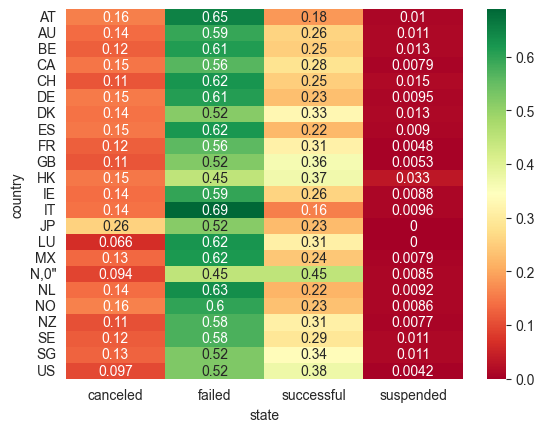

In [137]:
g = sns.heatmap(
    pd.crosstab(df['country'], df['state']).div(pd.crosstab(df['country'], df['state']).sum(axis=1), axis=0),
    annot=True, cmap="RdYlGn")

# Check null values

In [138]:
df.isnull().sum()

ID                                  0
category                            0
main_category                       0
currency                            0
goal                                0
pledged                             0
state                               0
backers                             0
country                             0
usd_pledged_realised at deadline    0
usd_goal_real_at_start              0
name_length                         0
name_length_qcut                    0
duration                            0
duration_qcut                       0
completeRatio                       0
dtype: int64

In [139]:
df.dropna(axis=0, inplace=True)
df.isnull().sum()

ID                                  0
category                            0
main_category                       0
currency                            0
goal                                0
pledged                             0
state                               0
backers                             0
country                             0
usd_pledged_realised at deadline    0
usd_goal_real_at_start              0
name_length                         0
name_length_qcut                    0
duration                            0
duration_qcut                       0
completeRatio                       0
dtype: int64

In [140]:
df.head()

,ID,category,main_category,currency,goal,pledged,state,backers,country,usd_pledged_realised at deadline,usd_goal_real_at_start,name_length,name_length_qcut,duration,duration_qcut,completeRatio
0,1000002330,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,1533.95,31,"(25.0, 34.0]",58,"(44.0, 59.0]",0.000000
1,1000003930,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,2421.0,30000.00,45,"(44.0, 54.0]",59,"(44.0, 59.0]",0.080700
2,1000004038,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,45000.00,14,"(0.999, 17.0]",44,"(41.0, 44.0]",0.004889
3,1000007540,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,5000.00,49,"(44.0, 54.0]",29,"(26.0, 29.0]",0.000200
4,1000011046,Film & Video,Film & Video,USD,19500.0,1283.0,canceled,14,US,1283.0,19500.00,58,"(54.0, 96.0]",55,"(44.0, 59.0]",0.065795


# Before actually take the data to the models, lets try Univariate selection

In [141]:
df.head()

,ID,category,main_category,currency,goal,pledged,state,backers,country,usd_pledged_realised at deadline,usd_goal_real_at_start,name_length,name_length_qcut,duration,duration_qcut,completeRatio
0,1000002330,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,1533.95,31,"(25.0, 34.0]",58,"(44.0, 59.0]",0.000000
1,1000003930,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,2421.0,30000.00,45,"(44.0, 54.0]",59,"(44.0, 59.0]",0.080700
2,1000004038,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,45000.00,14,"(0.999, 17.0]",44,"(41.0, 44.0]",0.004889
3,1000007540,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,5000.00,49,"(44.0, 54.0]",29,"(26.0, 29.0]",0.000200
4,1000011046,Film & Video,Film & Video,USD,19500.0,1283.0,canceled,14,US,1283.0,19500.00,58,"(54.0, 96.0]",55,"(44.0, 59.0]",0.065795


# Transform Category

In [142]:
def getTransformTable(colName, data):
    TransformTableData = {}
    stateSetData = set(data[colName])
    for index, i in enumerate(stateSetData):
        TransformTableData[i] = index
    return TransformTableData


backers_qcut = pd.qcut(df['backers'], 6)
usd_pledged_realised_at_deadline_qcut = pd.qcut(df['usd_pledged_realised at deadline'], 7)
usd_goal_real_at_start_qcut = pd.qcut(df['usd_goal_real_at_start'], 10)
completeRatio_qcut = pd.qcut(df['completeRatio'], 7)
categoricalDf = pd.concat(
    [
        backers_qcut,
        usd_pledged_realised_at_deadline_qcut,
        usd_goal_real_at_start_qcut,
        completeRatio_qcut]
    , axis=1)

categoricalDf.head()
num_encode = {
    'backers': getTransformTable('backers', categoricalDf),
    'usd_pledged_realised at deadline': getTransformTable('usd_pledged_realised at deadline', categoricalDf),
    'usd_goal_real_at_start': getTransformTable('usd_goal_real_at_start', categoricalDf),
    'completeRatio': getTransformTable('completeRatio', categoricalDf)
}

# Do Transformation
categoricalDf.replace(num_encode, inplace=True)
categoricalDf.head()

num_encode = {
    'category': getTransformTable('category', df),
    'state': getTransformTable('state', df),
    'main_category': getTransformTable('main_category', df),
    'currency': getTransformTable('currency', df),
    'country': getTransformTable('country', df),
    'name_length_qcut': getTransformTable('name_length_qcut', df),
    'duration_qcut': getTransformTable('duration_qcut', df)
}

# Do Transformation
df.replace(num_encode, inplace=True)

KeyboardInterrupt: 

In [ ]:
df.head()

# Feature Selection

# Normalize data

In [ ]:
continueiousFeatures = pd.concat([df[['goal', 'pledged', 'backers', 'usd_pledged_realised at deadline',
                                      'usd_goal_real_at_start', 'name_length', 'duration', 'completeRatio']]], axis=1)
categoricalFeatures = pd.concat(
    [df[['category', 'main_category', 'currency', 'country', 'name_length_qcut', 'duration_qcut']], categoricalDf],
    axis=1)
targetFeature = df['state']

In [ ]:
continueiousFeatures.head()

In [ ]:
categoricalFeatures.head()

In [ ]:
targetFeature.head()

Instead of using MinMaxScaler, here we use RobustScaler to solve the problem of outlines.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# scaler = MinMaxScaler()
scaler = RobustScaler()  # use RobustScaler to solve the problem of outlines.

normalized_df = pd.DataFrame(scaler.fit_transform(continueiousFeatures), columns=continueiousFeatures.columns,
                             index=continueiousFeatures.index)
normalized_df.head()

continueiousFeatures = normalized_df

# Perform Univariate selection - Select Continuous Features

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

data = continueiousFeatures
target = targetFeature

In [ ]:
data.head()

In [ ]:
best_features = SelectKBest(score_func=f_classif, k=6).fit(data, target)

dfscores = pd.DataFrame(best_features.scores_)
dfcolumns = pd.DataFrame(data.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns

print(featureScores.nlargest(10, 'Score'))

# Tree-based feature selection - Select Continuous Features

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

tree = ExtraTreesClassifier()
tree.fit(data, target)

df_feature_importances = pd.Series(tree.feature_importances_, index=data.columns)
df_feature_importances.nlargest(10).plot(kind='barh')

In [ ]:
combine = pd.concat([data, target], axis=1)
corr_mat = combine.corr()

# plt.figure(figsize=(20,20))
g = sns.heatmap(corr_mat, annot=True, cmap="RdYlGn")

# Drop features - Continuous Features

According to computer based selection and the figures/graphs above, we drop the following features.
* `usd pledged` (has been dropped earlier)
* `launched` (has been dropped earlier)
* `deadline` (has been dropped earlier)
* `goal`

In [ ]:
continueiousFeatures.drop(['goal'], axis=1, inplace=True)

# Perform Univariate selection - Select Categorical Features

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

data = categoricalFeatures
target = targetFeature

best_features = SelectKBest(score_func=f_classif, k=6).fit(data, target)

dfscores = pd.DataFrame(best_features.scores_)
dfcolumns = pd.DataFrame(data.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns

print(featureScores.nlargest(10, 'Score'))

# Tree-based feature selection - Select Categorical Features

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

tree = ExtraTreesClassifier()
tree.fit(data, target)

df_feature_importances = pd.Series(tree.feature_importances_, index=data.columns)
df_feature_importances.nlargest(10).plot(kind='barh')

# Mutual information (MI) - Select Categorical Features

In [ ]:
from sklearn.feature_selection import mutual_info_classif

data = mutual_info_classif(categoricalFeatures, targetFeature)

In [ ]:
for i in range(len(data)):
    print(categoricalFeatures.columns[i], list(data)[i])

# Drop features - Categorical Features

According to computer based selection and the figures/graphs above, we drop the following features.
* `usd_goal_real_at_start`
* `category`
* `country`
* `currency`

In [ ]:
categoricalFeatures.drop(['usd_goal_real_at_start', 'category', 'country', 'currency'], inplace=True, axis=1)

# Summary

The following features will be taken to the model and will be used in the following sections.

In [ ]:
continueiousFeatures.head()

In [ ]:
categoricalFeatures.head()

# One-hot vector conversion

In order to calculate the distance correctly, we need to transform the categorical features to one-hot vectors.

In [ ]:
onehot_df = pd.get_dummies(categoricalFeatures, prefix=categoricalFeatures.columns, columns=categoricalFeatures.columns,
                           drop_first=True)
onehot_df.head()

# Variables to store the best model (will be used to draw ROC curve)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

BestModels = {
    KNeighborsClassifier.__name__: {
        'accuracy': 0,
        'model': None
    },
    RandomForestClassifier.__name__: {
        'accuracy': 0,
        'model': None
    },
    DecisionTreeClassifier.__name__: {
        'accuracy': 0,
        'model': None
    },
    GaussianNB.__name__: {
        'accuracy': 0,
        'model': None
    },
    VotingClassifier.__name__: {
        'accuracy': 0,
        'model': None
    },

}


def updateBest(model, accuracyData):
    if accuracyData > BestModels[model.__name__]['accuracy']:
        BestModels[model.__name__]['model'] = model


# Prepare Training Data

In [144]:
class Data:
    X_train = None
    X_test = None
    X_val = None
    Y_train = None
    Y_test = None
    Y_val = None
data = Data()

train_val, test = train_test_split(pd.concat([continueiousFeatures, onehot_df, targetFeature], axis=1),
                               test_size=0.2)
train, val = train_test_split(train_val, test_size=0.2)
data.X_train, data.X_test, data.X_val = train.drop(["state"], axis=1), test.drop(["state"], axis=1), val.drop(["state"], axis=1)
data.Y_train, data.Y_test, data.Y_val  = train['state'], test['state'], val['state']

# KNN model with continuous features

In [ ]:
# Split data into training, validation and test sets
train, test = train_test_split(pd.concat([continueiousFeatures, targetFeature], axis=1), test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(f"Testing Model {KNeighborsClassifier.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']
neighbor_size = [3, 5, 7, 9, 11, 13]

metricNames = ["euclidean", "manhattan", "chebyshev"]
result = {}

for k in metricNames:
    result[k] = {}
    for neighbors in neighbor_size:
        print(f"Testing <metric: {k}, neighborSize: {neighbors}>: ", end="")
        knn = KNeighborsClassifier(n_neighbors=neighbors, metric=k, n_jobs=-1)
        print("training...", end=" ")
        knn.fit(X_train, y_train)
        print("evaluating...", end=" ")
        y_pred = knn.predict(X_test)
        print("calculating accuracy...", end=" ")
        accuracy = metrics.accuracy_score(y_test, y_pred)
        print("calculating f1...", end=" ")
        f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")
        print(f"\nResult: Accuracy {accuracy}, F1 {f1}")
        result[k][neighbors] = {
            "Accuracy": accuracy,
            "F1": f1
        }

In [ ]:
f = plt.figure(figsize=(12, 3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax1.bar(x - width + (width) * (index), [neighborResult[i]['Accuracy'] for i in neighborResult], width,
                   label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('K')
ax1.set_title('Accuracy by Distance Metric and K')
ax1.set_xticks(x, labels)
ax1.set_ylim([0, 1])
ax1.legend()

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax2.bar(x - width + (width) * (index), [neighborResult[i]['F1'] for i in neighborResult], width,
                   label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('F1')
ax2.set_xlabel('K')
ax2.set_title('F1 by Distance Metric and K')
ax2.set_xticks(x, labels)
ax2.set_ylim([0.2, 0.70])
ax2.legend()

plt.show()

# How dose the K setting affect the accuracy and f1 score?

As the number of neighbors increases the accuracy also increased, but the F1 score starts to dcrease.

This is because,

$$
F_1 = \frac{precision \times recall}{precision + recall}
$$

As the number of neighbors increase, the precision is also increasing. However, recall starts to drop. Which leads to the decrease of F1 score.

$$
F_1 = \frac{precision \uparrow \times recall \downarrow}{precision \uparrow + recall \downarrow} \downarrow
$$


In [ ]:
accuracy = []
f1_scores = []
x_values = list(range(1, 40))
# Calculating error for K values between 1 and 60
for i in x_values:
    print(f"current K : {i} ", end=" ")
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)  # 3 jobs will not use all the cores of my computer
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    acc = metrics.accuracy_score(y_test, pred_i)
    f1 = f1_score(y_true=y_test, y_pred=pred_i, average="macro")
    print(f"acc: {acc} F1: {f1} | ")
    accuracy.append(acc)
    f1_scores.append(f1)

plt.figure(figsize=(20, 6))
plt.plot(x_values, accuracy, color='red', marker='o',
         markersize=10)
plt.title('Accuracy Vs K')
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.figure(figsize=(20, 6))
plt.plot(x_values, f1_scores, color='yellow', marker='o',
         markersize=10)
plt.title('F1 Vs K')
plt.xlabel('K')
plt.ylabel('F1')

# What if we change the ratio of Test set and Train set?

From the graph below we can know that, if the test set is too large (ratio is too high), the model will *not be able to have enough instance to compare with*, which will leads to a drop in both $accuracy$ and $percision$.

In [ ]:
accuracy = []
f1_scores = []
x_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999, 0.9999]
# Calculating error for K values between 1 and 60
for i in x_values:
    train, test = train_test_split(pd.concat([continueiousFeatures, targetFeature], axis=1), test_size=i)
    X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
    y_train, y_test = train['state'], test['state']
    print(f"current test_size : {i} ", end=" ")
    knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    acc = metrics.accuracy_score(y_test, pred_i)
    f1 = f1_score(y_true=y_test, y_pred=pred_i, average="macro")
    print(f"acc: {acc} F1: {f1} | ")
    accuracy.append(acc)
    f1_scores.append(f1)

plt.figure(figsize=(20, 6))
plt.plot(x_values, accuracy, color='red', marker='o',
         markersize=10)
plt.title('Accuracy Vs test_size')
plt.xlabel('test_size')
plt.ylabel('Accuracy')

plt.figure(figsize=(20, 6))
plt.plot(x_values, f1_scores, color='yellow', marker='o',
         markersize=10)
plt.title('F1 Vs test_size')
plt.xlabel('test_size')
plt.ylabel('F1')

# KNN model with both continuous features and categorical features

Here I transformed the categorical features to one-hot vector, by doing this, KNN algorithm will be able to calculate the distance correctly for non-ordinal features i.e. `main_category` etc..

In [ ]:
# Split data into training, validation and test sets

train, test = train_test_split(pd.concat([continueiousFeatures, onehot_df, targetFeature], axis=1),
                               test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(f"Testing Model {KNeighborsClassifier.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']
neighbor_size = [3, 5, 7, 9, 11, 13]

metricNames = ["euclidean", "manhattan", "chebyshev"]
result = {}

for k in metricNames:
    result[k] = {}
    for neighbors in neighbor_size:
        print(f"Testing <metric: {k}, neighborSize: {neighbors}>: ", end="")
        knn = KNeighborsClassifier(n_neighbors=neighbors, metric=k,
                                   n_jobs=-1)  # 3 jobs will not use all the cores of my computer
        print("training...", end=" ")
        knn.fit(X_train, y_train)
        print("evaluating...", end=" ")
        y_pred = knn.predict(X_test)
        print("calculating accuracy...", end=" ")
        accuracy = metrics.accuracy_score(y_test, y_pred)
        print("calculating f1...", end=" ")
        f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")
        print(f"\nResult: Accuracy {accuracy}, F1 {f1}")
        result[k][neighbors] = {
            "Accuracy": accuracy,
            "F1": f1
        }
        updateBest(knn, accuracy)
# From the graph we can know that...


In [ ]:
f = plt.figure(figsize=(12, 3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax1.bar(x - width + (width) * (index), [neighborResult[i]['Accuracy'] for i in neighborResult], width,
                   label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('K')
ax1.set_title('Accuracy by Distance Metric and K')
ax1.set_xticks(x, labels)
ax1.set_ylim([0, 1])
ax1.legend()

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax2.bar(x - width + (width) * (index), [neighborResult[i]['F1'] for i in neighborResult], width,
                   label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('F1')
ax2.set_xlabel('K')
ax2.set_title('F1 by Distance Metric and K')
ax2.set_xticks(x, labels)
ax2.set_ylim([0.2, 0.70])
ax2.legend()

plt.show()

# RandomForestClassifier model with both continuous features and categorical features.

In [ ]:
# Split data into training, validation and test sets
train, test = train_test_split(pd.concat([continueiousFeatures, onehot_df, targetFeature], axis=1), test_size=0.3)
train, val = train_test_split(train, test_size=0.3)

print(f"Testing Model {RandomForestClassifier.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']
trees = [50, 100, 200, 500]
min_samples = [2, 3, 4, 5, 6]
result = {}

for k in trees:
    result[k] = {}
    for minSamples in min_samples:
        print(f"Testing <trees: {k}, min_samples: {minSamples}>: ", end="")
        rf = RandomForestClassifier(random_state=1, min_samples_split=minSamples, n_estimators=k)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")
        print(f"Result: Accuracy {accuracy}, F1 {f1}")
        result[k][neighbors] = {
            "Accuracy": accuracy,
            "F1": f1
        }
        updateBest(rf, accuracy)


In [ ]:
f = plt.figure(figsize=(12, 3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax1.bar(x - width + (width) * (index), [neighborResult[i]['Accuracy'] for i in neighborResult], width,
                   label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('trees')
ax1.set_title('Accuracy by trees and min_samples')
ax1.set_xticks(x, labels)
ax1.set_ylim([0, 1])
ax1.legend()

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax2.bar(x - width + (width) * (index), [neighborResult[i]['F1'] for i in neighborResult], width,
                   label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('F1')
ax2.set_xlabel('trees')
ax2.set_title('F1 by trees and min_samples')
ax2.set_xticks(x, labels)
ax2.set_ylim([0.2, 0.70])
ax2.legend()

plt.show()

# Decision Tree - For categorical features

In [ ]:
from sklearn import metrics, tree

train, test = train_test_split(pd.concat([categoricalFeatures, targetFeature], axis=1), test_size=0.3)
train, val = train_test_split(train, test_size=0.3)

print(f"Testing Model {DecisionTreeClassifier.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']

entropy_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
entropy_tree.fit(X_train, y_train)
y_pred = entropy_tree.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
updateBest(entropy_tree, accuracy)

print(metrics.classification_report(y_test, y_pred))
print("Accuracy:", accuracy)

# GaussianNB - For categorical features


In [ ]:
train, test = train_test_split(pd.concat([categoricalFeatures, targetFeature], axis=1), test_size=0.3)
train, val = train_test_split(train, test_size=0.3)
print(f"Testing Model {GaussianNB.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']
metricValue = range(1, 10)
result = {}
accuracy = []
xData = []
for k in metricValue:
    result[k] = {}
    print(f"Testing <metric: {k}>: ", end="")
    gn = GaussianNB(var_smoothing=0.1 ** k)
    xData.append(0.1 ** k)
    gn.fit(X_train, y_train)
    y_pred = gn.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accuracy.append(acc)
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")
    print(f"Result: Accuracy {acc}, F1 {f1}")
    result[k][0] = {
        "Accuracy": accuracy,
        "F1": f1
    }
    updateBest(gn, accuracy)


In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(xData, accuracy, color='red', marker='o',
         markersize=10)
plt.title('Accuracy Vs var_smoothing Value')
plt.xlabel('var_smoothing Value')
plt.ylabel('Accuracy')

In [ ]:
train, test = train_test_split(pd.concat([continueiousFeatures, onehot_df, targetFeature], axis=1), test_size=0.3)
train, val = train_test_split(train, test_size=0.3)
print(f"Testing Model {VotingClassifier.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']

tree_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
randf_clf = RandomForestClassifier()

voting_clf = VotingClassifier([('decTree', tree_clf), ('KNN', knn_clf), ('RandForest', randf_clf)], weights=None,
                              verbose=True)
voting_clf.fit(X_train, y_train.values.ravel())

In [ ]:
from sklearn.metrics import classification_report

pred = voting_clf.predict(X_test)
print(classification_report(y_pred=pred, y_true=y_test))
accuracy = metrics.accuracy_score(y_test, pred)

updateBest(voting_clf, accuracy)
print("Accuracy: ", accuracy)